In [1]:
import os
import numpy as np
import typing as t
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

from v1t.utils import utils, yaml, tensorboard

utils.set_random_seed(1234)

tensorboard.set_font()

TRAIN_SIZES = [500, 1500, 2500, 3500, 4500]

In [2]:
def get_results(dir: str):
    results = {}
    for train_size in TRAIN_SIZES:
        if train_size not in results:
            results[train_size] = {}
        for model in ["stacked2d", "v1t"]:
            if model not in results[train_size]:
                results[train_size][model] = []
            output_dirs = glob(os.path.join(dir, str(train_size), model, "*"))
            for output_dir in output_dirs:
                filename = os.path.join(output_dir, "evaluation.yaml")
                if os.path.exists(filename):
                    result = yaml.load(filename)
                    results[train_size][model].append(
                        result["single_trial_correlation"]["average"]
                    )
    return results


results = get_results("../runs/limit_data")

In [3]:
def p_value_to_asterisks(p_value: float):
    text = "n.s."
    if p_value <= 0.0001:
        text = "****"
    elif p_value <= 0.001:
        text = "***"
    elif p_value <= 0.01:
        text = "**"
    elif p_value <= 0.05:
        text = "*"
    return text


def get_summary(results: t.Dict[int, t.Dict[str, t.List[float]]]):
    cnn_mean, cnn_std = [], []
    v1t_mean, v1t_std = [], []
    p_values = []
    for train_size, result in results.items():
        cnn, v1t = result["stacked2d"], result["v1t"]
        if len(cnn) != len(v1t):
            print(
                f"V1T and CNN (train size: {train_size}) have different number of experiments: {len(v1t)} vs {len(cnn)}."
            )

        cnn_mean.append(np.mean(cnn))
        cnn_std.append(np.std(cnn))
        v1t_mean.append(np.mean(v1t))
        v1t_std.append(np.std(v1t))
        t_test = ttest_ind(cnn, v1t)
        p_values.append(p_value_to_asterisks(t_test.pvalue))
    return cnn_mean, cnn_std, v1t_mean, v1t_std, p_values


cnn_mean, cnn_std, v1t_mean, v1t_std, p_values = get_summary(results)

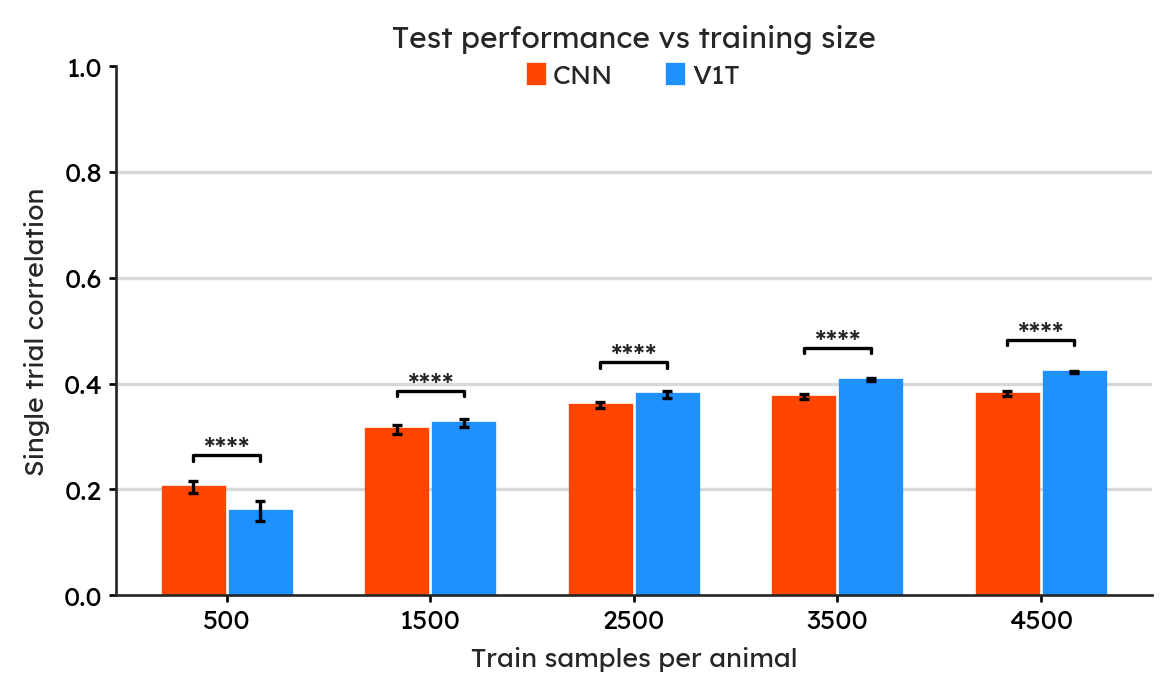

In [4]:
annot_fontsize, tick_fontsize, label_fontsize, title_fontsize = 7, 8, 8, 9
width, y_max, bar_pad = 0.3, 1.0, 0.015
error_kw = {"elinewidth": 1, "capsize": 1.5}
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(5, 3), dpi=240)

x_axis = np.arange(1, len(TRAIN_SIZES) + 1)
x_labels = TRAIN_SIZES

# plot CNN results
axis.bar(
    x_axis - width / 2 - bar_pad,
    height=cnn_mean,
    yerr=cnn_std,
    width=width,
    align="center",
    label="CNN",
    color="orangered",
    edgecolor="orangered",
    error_kw=error_kw,
)


# plot V1T results
axis.bar(
    x_axis + width / 2 + bar_pad,
    height=v1t_mean,
    yerr=v1t_std,
    width=width,
    align="center",
    label="V1T",
    color="dodgerblue",
    edgecolor="dodgerblue",
    error_kw=error_kw,
)

axis.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.05),
    ncols=2,
    frameon=False,
    handletextpad=0.35,
    handlelength=0.6,
    markerscale=0.8,
    columnspacing=2,
    fontsize=label_fontsize,
)

tensorboard.set_xticks(
    axis,
    ticks_loc=x_axis,
    ticks=x_labels,
    label="Train samples per animal",
    tick_fontsize=tick_fontsize,
    label_fontsize=label_fontsize,
)
axis.set_ylim(0, y_max)
y_ticks = np.linspace(0, y_max, 6)
tensorboard.set_yticks(
    axis,
    ticks_loc=y_ticks,
    ticks=y_ticks.round(1),
    label="Single trial correlation",
    tick_fontsize=tick_fontsize,
    label_fontsize=label_fontsize,
)

# plot y-axis grid lines
for y_value in y_ticks:
    if 0 < y_value < y_max:
        axis.axhline(y_value, color="gray", alpha=0.3, linewidth=1, zorder=0)

# plot p-value asterisks
for i in range(len(TRAIN_SIZES)):
    x_start = x_axis[i]
    mid = width / 2
    lx = x_start - mid - bar_pad
    rx = x_start + mid + bar_pad
    y = max(v1t_mean[i], cnn_mean[i]) + 0.05
    barx = [lx, lx, rx, rx]
    y_offset = 0.01
    bary = [y, y + y_offset, y + y_offset, y]
    axis.plot(barx, bary, color="black", linewidth=1)
    axis.text(
        x=(lx + rx) / 2,
        y=y - 0.005,
        s=p_values[i],
        ha="center",
        va="bottom",
        fontsize=title_fontsize,
    )

sns.despine(ax=axis, top=True, right=True, trim=False)
tensorboard.set_ticks_params(axis=axis, length=2)

axis.set_title("Test performance vs training size", fontsize=title_fontsize, y=1)

figure.tight_layout()

tensorboard.save_figure(figure, filename=f"plots/limit_data.jpg", dpi=240, close=False)

plt.show()
plt.close(figure)

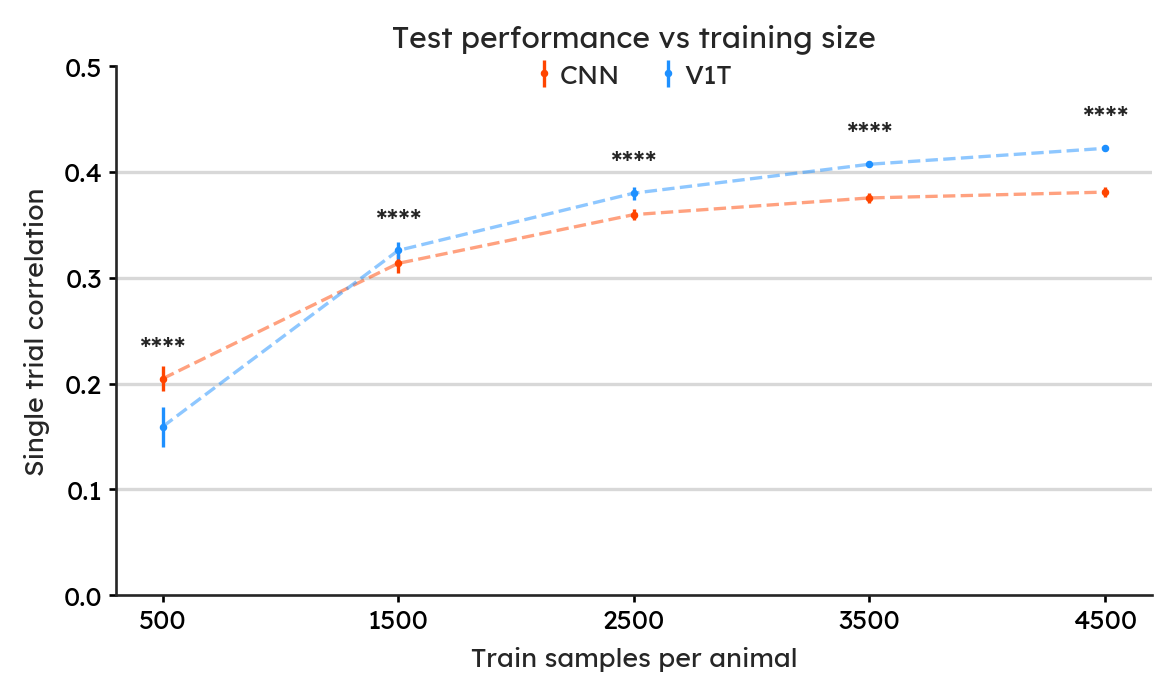

In [5]:
annot_fontsize, tick_fontsize, label_fontsize, title_fontsize = 7, 8, 8, 9
y_max = 0.5
markersize = 2.5
capsize = 0
elinewidth = 1
line_alpha = 0.5
error_kw = {"elinewidth": 1, "capsize": 1.8}
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(5, 3), dpi=240)

x_axis = np.arange(1, len(TRAIN_SIZES) + 1)
x_labels = TRAIN_SIZES

# plot CNN results
axis.errorbar(
    x_axis,
    cnn_mean,
    yerr=cnn_std,
    markersize=markersize,
    fmt=".",
    capsize=capsize,
    elinewidth=elinewidth,
    color="orangered",
    label="CNN",
)
axis.plot(
    x_axis,
    cnn_mean,
    alpha=line_alpha,
    color="orangered",
    linestyle="--",
    linewidth=1,
)

# plot V1T results
axis.errorbar(
    x_axis,
    v1t_mean,
    yerr=v1t_std,
    markersize=markersize,
    fmt=".",
    capsize=capsize,
    elinewidth=elinewidth,
    color="dodgerblue",
    label="V1T",
)
axis.plot(
    x_axis,
    v1t_mean,
    alpha=line_alpha,
    color="dodgerblue",
    linestyle="--",
    linewidth=1,
)

axis.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.05),
    ncols=2,
    frameon=False,
    handletextpad=0.3,
    handlelength=0.6,
    markerscale=1,
    columnspacing=1.5,
    fontsize=label_fontsize,
)

tensorboard.set_xticks(
    axis,
    ticks_loc=x_axis,
    ticks=x_labels,
    label="Train samples per animal",
    tick_fontsize=tick_fontsize,
    label_fontsize=label_fontsize,
)
axis.set_ylim(0, y_max)
y_ticks = np.linspace(0, y_max, 6)
tensorboard.set_yticks(
    axis,
    ticks_loc=y_ticks,
    ticks=y_ticks.round(1),
    label="Single trial correlation",
    tick_fontsize=tick_fontsize,
    label_fontsize=label_fontsize,
)

# plot y-axis grid lines
for y_value in y_ticks:
    if 0 < y_value < y_max:
        axis.axhline(y_value, color="gray", alpha=0.3, linewidth=1, zorder=0)

# plot p-value asterisks
for i in range(len(TRAIN_SIZES)):
    axis.text(
        x=x_axis[i],
        y=max(cnn_mean[i], v1t_mean[i]) + 0.015,
        s=p_values[i],
        ha="center",
        va="bottom",
        fontsize=title_fontsize,
    )

sns.despine(ax=axis, top=True, right=True, trim=False)
tensorboard.set_ticks_params(axis=axis, length=2)

axis.set_title("Test performance vs training size", fontsize=title_fontsize, y=1)

figure.tight_layout()

tensorboard.save_figure(
    figure, filename=f"plots/limit_data_1.jpg", dpi=240, close=False
)

plt.show()
plt.close(figure)